In [1]:
import os
import findspark
findspark.init()
import pyspark
from pyspark import SQLContext
sc = pyspark.SparkContext(master='spark://192.168.11.239:7077', appName='holiday_effects')

In [91]:
from pyspark.sql.types import *
sqlContext = SQLContext(sc)
from datetime import datetime, timedelta
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType
import matplotlib
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

In [3]:
df = sqlContext.read.csv("/datasets/crimes.csv", header='true')
df.count()

7063815

In [4]:
df = (df
       .withColumn('Day', F.to_date("Date", 'MM/dd/yyyy hh:mm:ss a'))
      )

## Generate US Holidays

In [5]:
def generate_US_holidays(start,end,state="IL"):
    hdays = holidays.UnitedStates(years=list(np.arange(start,end+1)),state=state).items()
    hdays = dict(list(hdays)) #Convert to dict since it is immutable
    return {str(k):v for k,v in hdays.items()} #Want Y-m-d format

In [6]:
generate_US_holidays(2010,2011)

{'2010-01-01': "New Year's Day",
 '2010-12-31': "New Year's Day (Observed)",
 '2010-01-18': 'Martin Luther King, Jr. Day',
 '2010-02-12': "Lincoln's Birthday",
 '2010-02-15': "Washington's Birthday",
 '2010-03-01': 'Casimir Pulaski Day',
 '2010-05-31': 'Memorial Day',
 '2010-07-04': 'Independence Day',
 '2010-07-05': 'Independence Day (Observed)',
 '2010-09-06': 'Labor Day',
 '2010-10-11': 'Columbus Day',
 '2010-11-02': 'Election Day',
 '2010-11-11': 'Veterans Day',
 '2010-11-25': 'Thanksgiving',
 '2010-12-25': 'Christmas Day',
 '2010-12-24': 'Christmas Day (Observed)',
 '2011-01-01': "New Year's Day",
 '2011-01-17': 'Martin Luther King, Jr. Day',
 '2011-02-12': "Lincoln's Birthday",
 '2011-02-11': "Lincoln's Birthday (Observed)",
 '2011-02-21': "Washington's Birthday",
 '2011-03-07': 'Casimir Pulaski Day',
 '2011-05-30': 'Memorial Day',
 '2011-07-04': 'Independence Day',
 '2011-09-05': 'Labor Day',
 '2011-10-10': 'Columbus Day',
 '2011-11-11': 'Veterans Day',
 '2011-11-24': 'Thanksgiv

In [7]:
us_hdays = generate_US_holidays(2001,2020)
print("There are ",len(us_hdays), " holidays from 2001 to 2020 in the dataset")

There are  273  holidays from 2001 to 2020 in the dataset


### Add label to rows wich is on a holiday

We start of by adding a binary yes or no (1/0) if each row is on a holiday. Some holidays are so called Observed Holidays, so we can also add an additional column which specifies whether or not it is an Observed holiday.

In [8]:
@udf(IntegerType())
def is_holiday(_date):
    if str(_date) in us_hdays.keys():
        return 1
    else:
        return 0
    
    
    
@udf(IntegerType())
def is_obserbed_holiday(_date):
    if str(_date) in us_hdays.keys():
        if '(Observed)' in us_hdays[str(_date)]:
            return 1
    return 0



@udf(StringType())
def holiday_desc(_date):
    if str(_date) in us_hdays.keys():
        return us_hdays[str(_date)]
    else:
        return "none"

In [9]:
df = (df\
        .withColumn('Holiday', is_holiday(F.col('Day')))\
        .withColumn('Observed', is_obserbed_holiday(F.col('Day')))\
        .withColumn('HolidayDesc', holiday_desc(F.col('Day'))))

In [10]:
df.select("Day","Holiday","Observed","HolidayDesc").show(15)

+----------+-------+--------+--------------+
|       Day|Holiday|Observed|   HolidayDesc|
+----------+-------+--------+--------------+
|2001-01-01|      1|       0|New Year's Day|
|2017-10-08|      0|       0|          none|
|2017-03-28|      0|       0|          none|
|2017-09-09|      0|       0|          none|
|2017-08-26|      0|       0|          none|
|2013-02-10|      0|       0|          none|
|2015-01-01|      1|       0|New Year's Day|
|2017-01-01|      1|       0|New Year's Day|
|2017-07-17|      0|       0|          none|
|2017-12-28|      0|       0|          none|
|2017-02-10|      0|       0|          none|
|2017-11-22|      0|       0|          none|
|2012-01-01|      1|       0|New Year's Day|
|2017-07-29|      0|       0|          none|
|2017-01-22|      0|       0|          none|
+----------+-------+--------+--------------+
only showing top 15 rows



In [11]:
df_hday = (df\
           .groupBy("Day","Holiday","Observed","HolidayDesc")\
           .count()\
           .sort(F.col("Day"))\
           .toPandas()\
           .set_index('Day'))

In [12]:
df_hday.head()

,Holiday,Observed,HolidayDesc,count
Day,,,,
2001-01-01,1,0,New Year's Day,1819
2001-01-02,0,0,none,1143
2001-01-03,0,0,none,1151
2001-01-04,0,0,none,1166
2001-01-05,0,0,none,1267


In [20]:
df_hday.index = pd.DatetimeIndex(df_hday.index) #So we can extract date derivatives easily

Plot holiday effects from each year in the dataset (Ignore Observed Holidays)

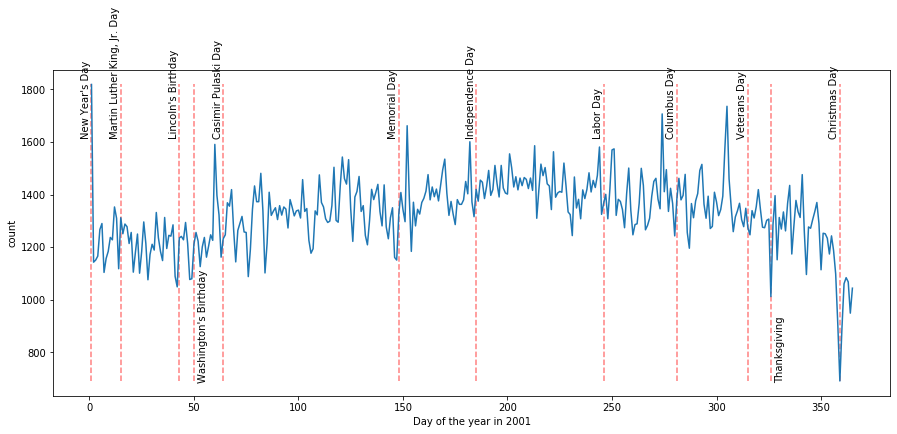

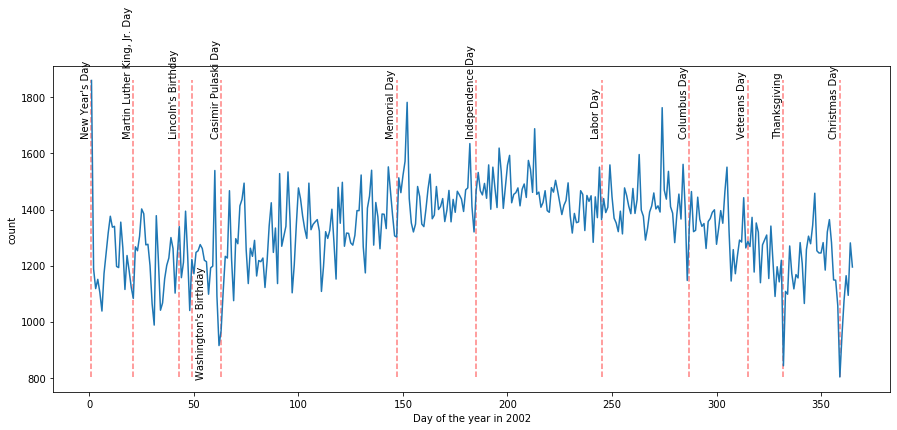

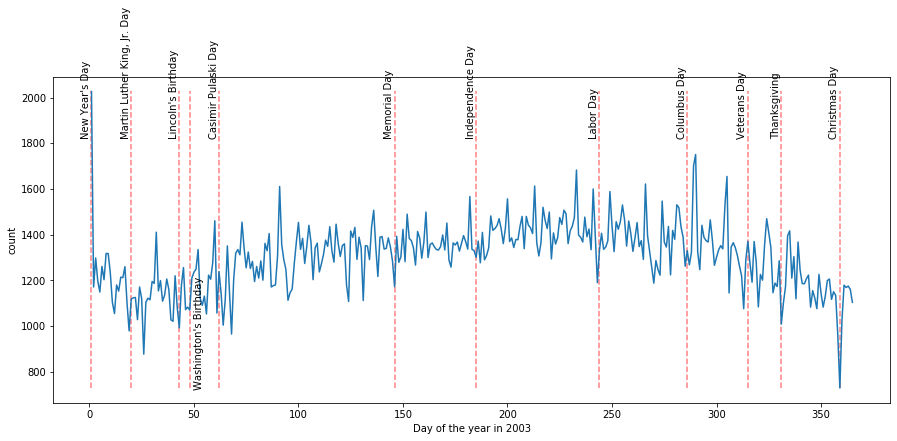

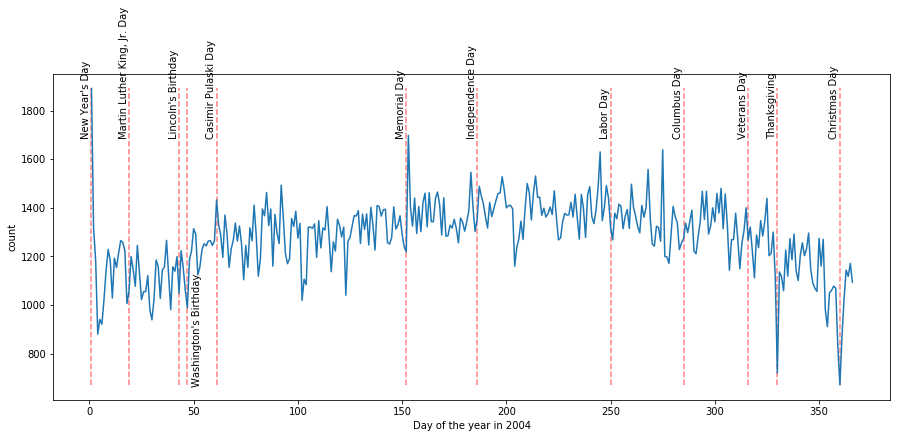

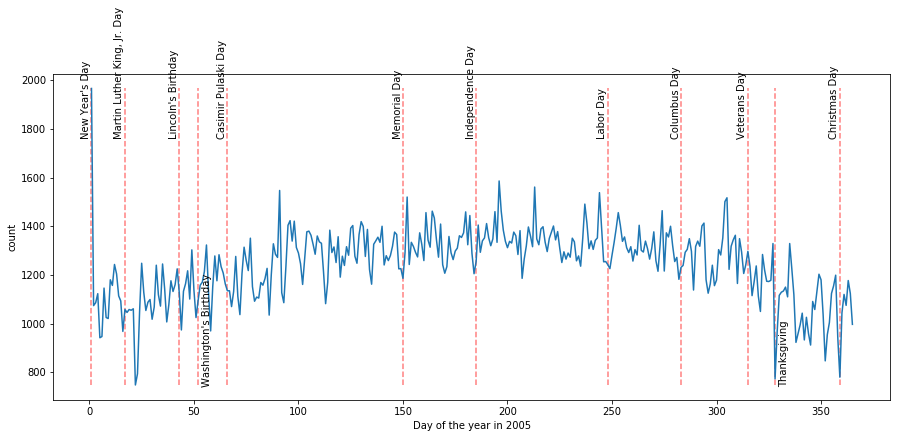

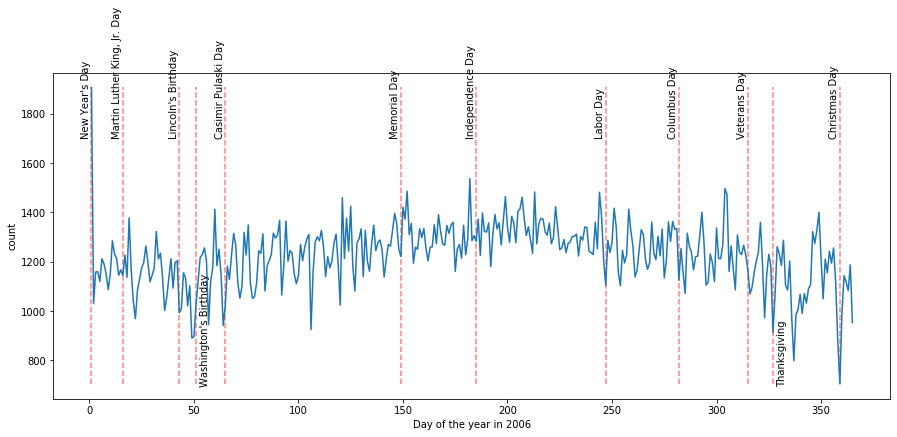

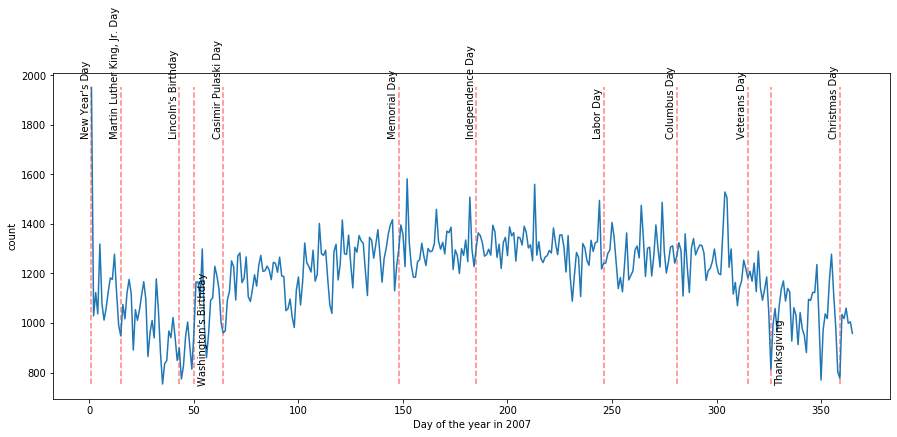

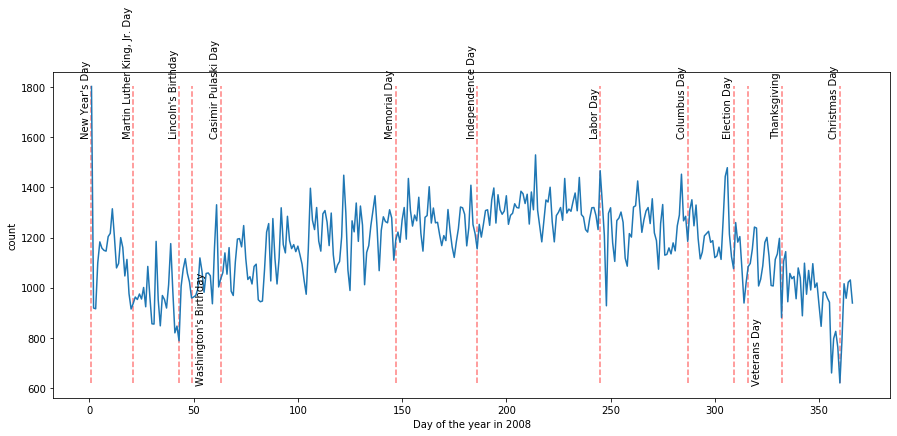

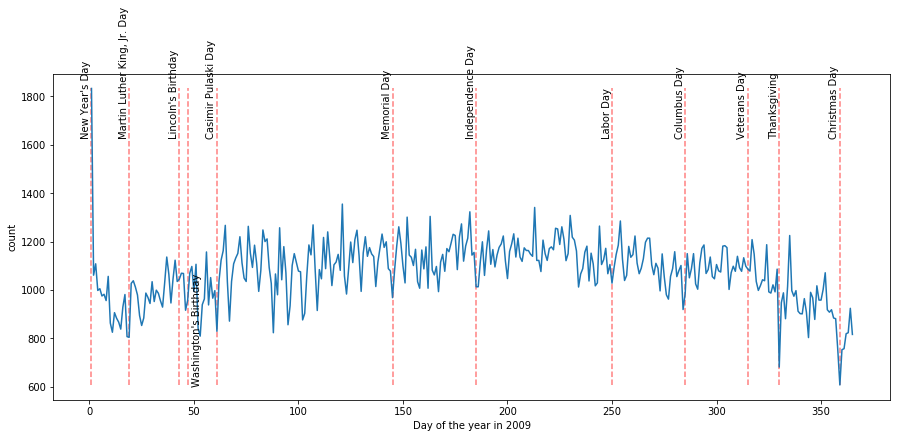

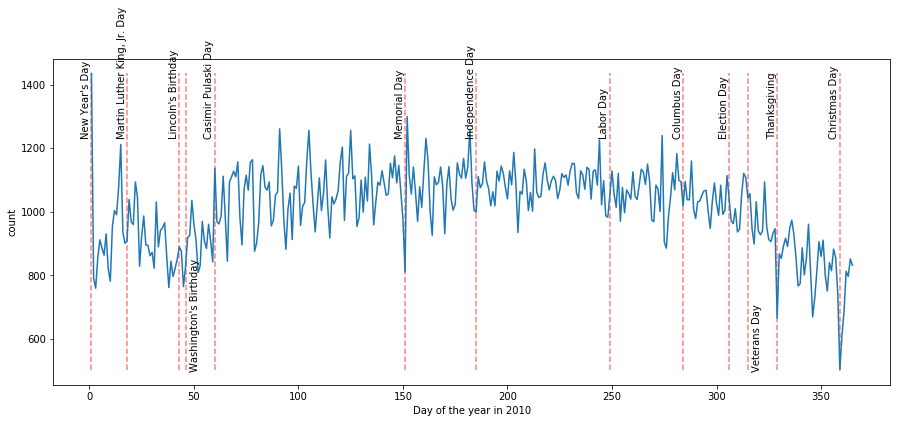

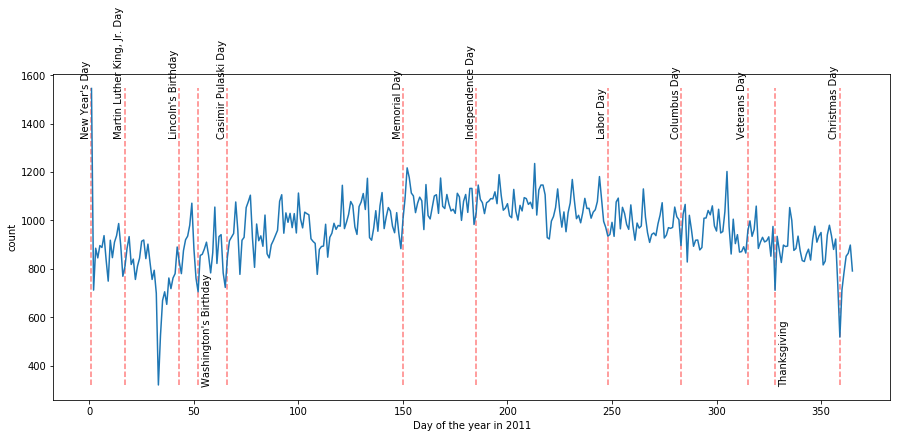

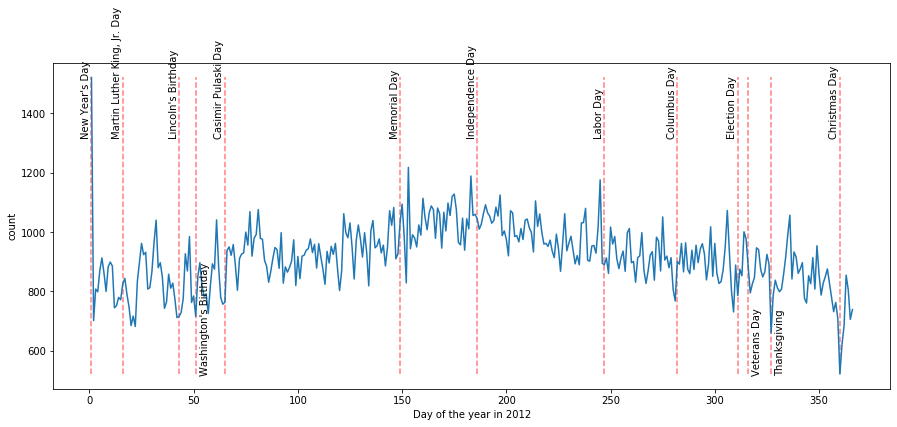

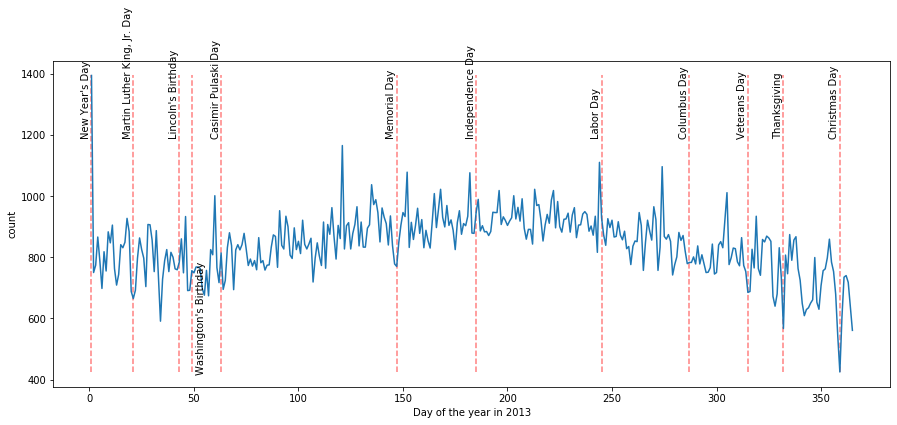

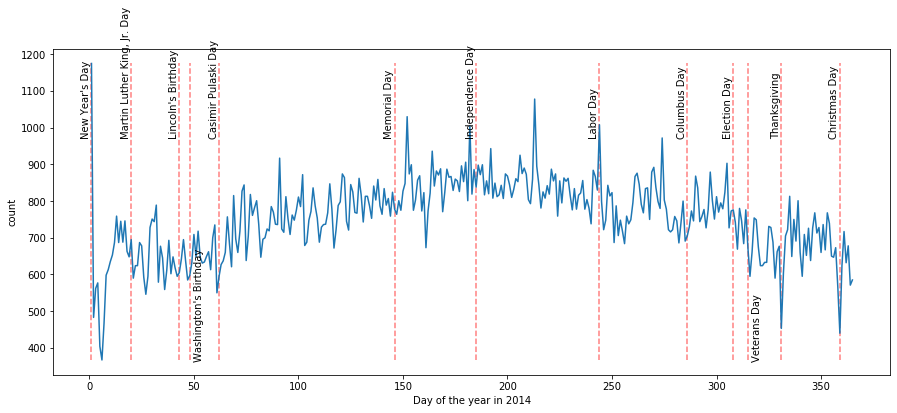

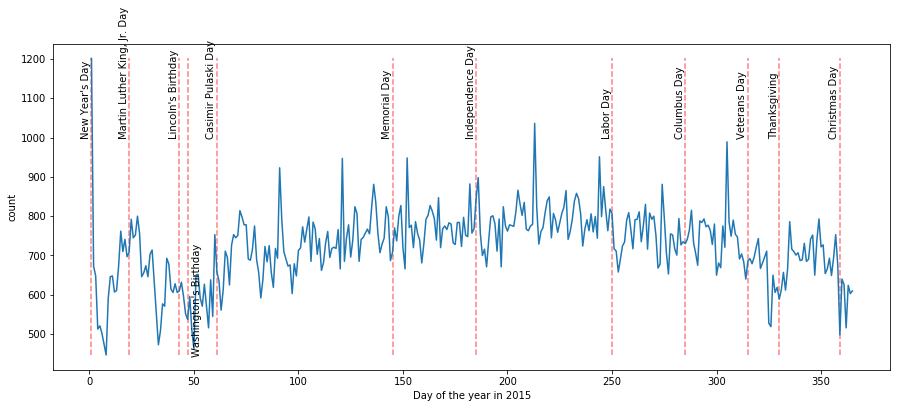

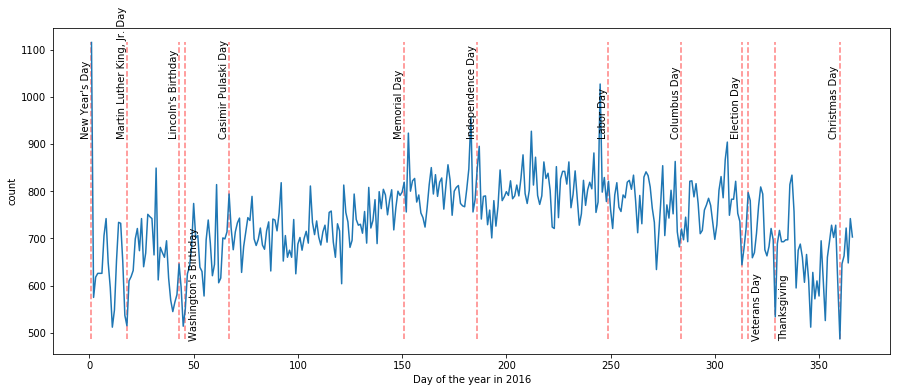

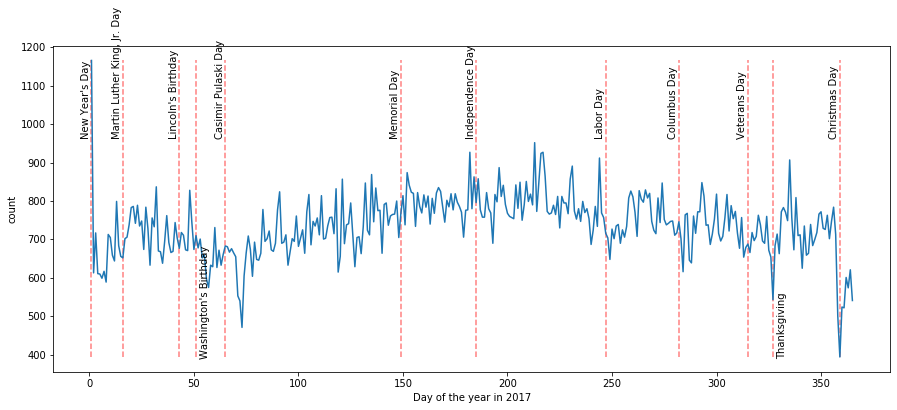

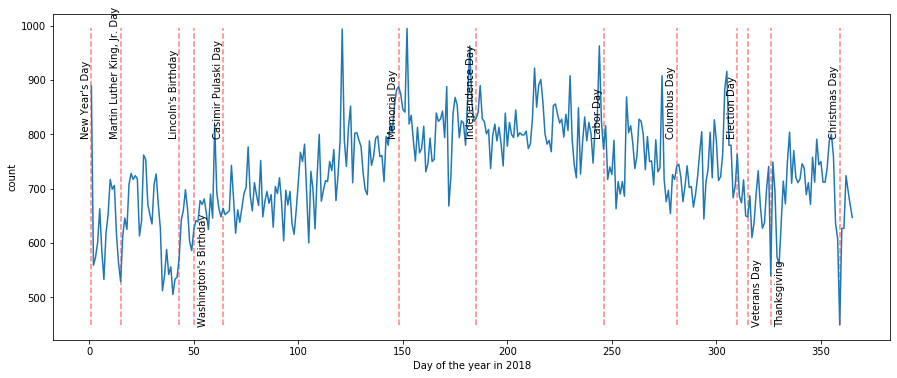

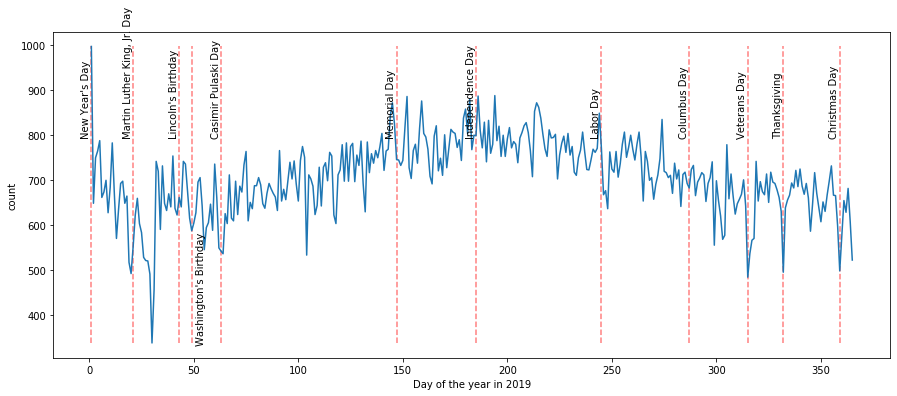

In [80]:
for year in np.arange(2001,2020):

    _df = df_hday[df_hday.index.year == year]
    _hdays = _df[(_df.Holiday == 1) & (_df.Observed == 0)].index.dayofyear
    _hdays_names = _df[(_df.Holiday == 1) & (_df.Observed == 0)]["HolidayDesc"]

    fig, ax = plt.subplots(figsize=(15,6))
    sns.lineplot(x=_df.index.dayofyear,
                y=_df["count"],
                ax=ax,
                data=_df)

    plt.xlabel('Day of the year in ' + str(year))

    plt.vlines(_hdays,
               ymin = _df["count"].min(),
               ymax = _df["count"].max(),
               linestyle='--',
               alpha=0.5,
               color ='r'
              )


    last_text = 0
    for i,v in enumerate(_hdays):
        x_text = v-5
        y_text = _df["count"].max()-200
        if v>1 and v - last_text < 14: #Less than 14 days between
            x_text += 7 #Put it on the bottom and on the right side
            y_text = _df["count"].min()
        
        last_text = v
            
        plt.text(x=x_text, y=y_text, s=_hdays_names[i],rotation=90)
    plt.show()

We can see that New Years Day, Christmas Day, Thanksgiving, Election day, Washingtons Birthday has clear effects year after year. Also clear spike days before Independence day. We can zoom in to some holidays and observe their influence (in this case 2019).

Algorithm:

1. Filter the dataframe by year and holiday
2. For each holiday of interest, generate a daterange before and after in order to capture the effect
3. Put it into a new dataframe and append it to a list
4. For each dataframe in the list, plot the effects

In [132]:
days_to_check = ["New Year's Day","Christmas Day","Thanksgiving"]

_df = df_hday[df_hday.index.year == 2019]
_df_list = []
for v in _df[(_df.Holiday == 1) & (_df.Observed == 0)]["HolidayDesc"].items():
    if v[1] in days_to_check:
        print(v[1])
        print(v[0])
        print(v[0].strftime("%Y-%m-%d"))
        print(v[0] - timedelta(days=4))
        date_idx = pd.date_range(start=v[0] - timedelta(days=3), periods=7)
        print(date_idx)
        _df_list.append(df_hday.loc[date_idx])

New Year's Day
2019-01-01 00:00:00
2019-01-01
2018-12-28 00:00:00
DatetimeIndex(['2018-12-29', '2018-12-30', '2018-12-31', '2019-01-01',
               '2019-01-02', '2019-01-03', '2019-01-04'],
              dtype='datetime64[ns]', freq='D')
Thanksgiving
2019-11-28 00:00:00
2019-11-28
2019-11-24 00:00:00
DatetimeIndex(['2019-11-25', '2019-11-26', '2019-11-27', '2019-11-28',
               '2019-11-29', '2019-11-30', '2019-12-01'],
              dtype='datetime64[ns]', freq='D')
Christmas Day
2019-12-25 00:00:00
2019-12-25
2019-12-21 00:00:00
DatetimeIndex(['2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28'],
              dtype='datetime64[ns]', freq='D')


<Figure size 432x288 with 0 Axes>

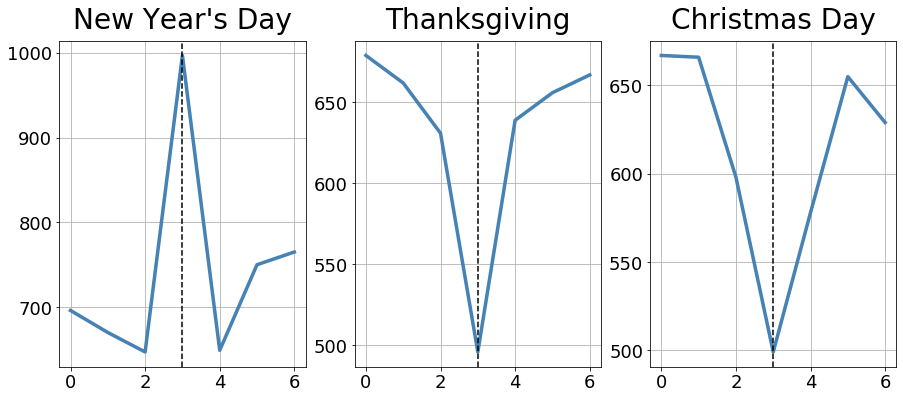

In [178]:
plt.clf()
fig,ax = plt.subplots(1,3, sharex=False, sharey=False,figsize=(15,6))
for i,v in enumerate(_df_list):
    ax[i].plot(np.arange(0,len(v)),v["count"].values, linewidth=3.5, c="steelblue")
    ax[i].axvline(x=3, color='k', linestyle='--')
    ax[i].set_title(v[3:4]["HolidayDesc"].values[0], fontsize=28, pad=12)
    ax[i].locator_params(axis='y', nbins=5)
    ax[i].locator_params(axis='x', nbins=4)
    ax[i].grid(True)
    ax[i].tick_params(axis='both', labelsize=18)
    
plt.savefig('holiday_effect.png')
plt.show()